In [1]:
import pandas as pd
import time
import geopandas
from glob import glob
from shapely.ops import cascaded_union
import pickle
import matplotlib.pyplot as plt

In [2]:
bids = pd.read_csv("data/all_bids.csv")[["round", "bidder", "tier", "latency", "census_id"]]
bids["state"] = bids["census_id"]//10000000000
bids_unfiltered = bids
bids = bids.drop_duplicates(subset=["bidder", "census_id"])
bids

,round,bidder,tier,latency,census_id,state
0,1,Rainbow Communications LLC,Gigabit,Low,200050816001,20
1,1,Rainbow Communications LLC,Gigabit,Low,200050816002,20
2,1,Rainbow Communications LLC,Gigabit,Low,200050816003,20
3,1,Rainbow Communications LLC,Gigabit,Low,200050816005,20
4,1,Rainbow Communications LLC,Gigabit,Low,200050817002,20
...,...,...,...,...,...,...
4038929,13,Consortium of AEG and Heron Broadband I,Gigabit,Low,271159503002,27
4038930,13,Consortium of AEG and Heron Broadband I,Gigabit,Low,271159504001,27
4039029,13,Consortium of AEG and Heron Broadband I,Gigabit,Low,270753701003,27
4039401,13,Consortium of AEG and Heron Broadband I,Gigabit,Low,550539604003,55


In [3]:
existing = pd.read_csv("data/existing_service.csv", encoding="latin")
existing["bg"] = existing["BlockCode"]//1000
existing  = existing.loc[(existing["MaxAdDown"]>=25) & (existing["MaxAdUp"]>=3) & (existing["TechCode"]!=60)]
existing["state"] = existing["bg"]//10000000000
existing['names'] = [frozenset(x) for x in zip(existing.ProviderName, existing.HoldingCompanyName, existing.DBAName, existing.HocoFinal)]
existing

,LogRecNo,Provider_Id,FRN,ProviderName,DBAName,HoldingCompanyName,HocoNum,HocoFinal,StateAbbr,BlockCode,TechCode,Consumer,MaxAdDown,MaxAdUp,Business,bg,state,names
0,1,59590,17678236,Webformix Company,Webformix,Webformix Company,290118,Webformix Company,OR,410139501002019,70,1,40.0,10.0,1,410139501002,41,"(Webformix Company, Webformix)"
1,2,59590,17678236,Webformix Company,Webformix,Webformix Company,290118,Webformix Company,OR,410139503002023,70,1,40.0,10.0,1,410139503002,41,"(Webformix Company, Webformix)"
2,3,59590,17678236,Webformix Company,Webformix,Webformix Company,290118,Webformix Company,OR,410139502002027,70,1,40.0,10.0,1,410139502002,41,"(Webformix Company, Webformix)"
3,4,59590,17678236,Webformix Company,Webformix,Webformix Company,290118,Webformix Company,OR,410139501003004,70,1,40.0,10.0,1,410139501003,41,"(Webformix Company, Webformix)"
4,5,59590,17678236,Webformix Company,Webformix,Webformix Company,290118,Webformix Company,OR,410139504001109,70,1,40.0,10.0,1,410139504001,41,"(Webformix Company, Webformix)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42151570,42151571,79963,21999305,OSNET Wireless Corp.,OSNET Wireless,OSNET Wireless Corp.,420091,Osnet Wireless Corp.,PR,720054006003006,70,1,30.0,10.0,1,720054006003,72,"(OSNET Wireless Corp., OSNET Wireless, Osnet W..."
42151571,42151572,79963,21999305,OSNET Wireless Corp.,OSNET Wireless,OSNET Wireless Corp.,420091,Osnet Wireless Corp.,PR,720054006003005,70,1,30.0,10.0,1,720054006003,72,"(OSNET Wireless Corp., OSNET Wireless, Osnet W..."
42151572,42151573,79963,21999305,OSNET Wireless Corp.,OSNET Wireless,OSNET Wireless Corp.,420091,Osnet Wireless Corp.,PR,720054006003004,70,1,30.0,10.0,1,720054006003,72,"(OSNET Wireless Corp., OSNET Wireless, Osnet W..."
42151573,42151574,79963,21999305,OSNET Wireless Corp.,OSNET Wireless,OSNET Wireless Corp.,420091,Osnet Wireless Corp.,PR,720054006003003,70,1,30.0,10.0,1,720054006003,72,"(OSNET Wireless Corp., OSNET Wireless, Osnet W..."


In [4]:
existing_bg = set(existing["bg"].tolist())
bid_bg = set(bids["census_id"].tolist())
print(len(existing_bg))
print(len(bid_bg))
print(len(existing_bg.intersection(bid_bg)))


219391
61766
61021


In [5]:
eligible = pd.read_csv("data/auction904_updated_block_cbg.csv")
eligible_bg = eligible["cbg_id"].tolist()
print(len(set(eligible_bg)))
eligible_b = eligible["block_id"].tolist()
existing_b = set(existing["BlockCode"].tolist())
print(len(existing_b))
print(len(eligible_b))
intersect = existing_b.intersection(eligible_b)
print(len(existing_b.intersection(eligible_b)))
print(list(intersect)[:5])


61766
8063170
786952
292114
[170679543005184, 170679543005185, 170679543005186, 170679543005187, 170679543005188]


In [6]:
shapefiles = glob("data/all_data/*.shp")
county_shapes = []
for file in  shapefiles:
    county_shapes.append(geopandas.read_file(file))

county_shapes = pd.concat(county_shapes)[["STATEFP", "COUNTYFP", "TRACTCE", "BLKGRPCE", "GEOID", "geometry"]]
county_shapes["GEOID"] = pd.to_numeric(county_shapes["GEOID"])
county_shapes

,STATEFP,COUNTYFP,TRACTCE,BLKGRPCE,GEOID,geometry
0,05,143,010503,2,51430105032,"POLYGON ((-94.21915 36.17593, -94.21718 36.175..."
1,05,143,010504,1,51430105041,"POLYGON ((-94.33762 35.97984, -94.33724 35.980..."
2,05,143,010504,5,51430105045,"POLYGON ((-94.43864 35.95907, -94.43852 35.959..."
3,05,143,010506,1,51430105061,"POLYGON ((-94.24059 36.04502, -94.24058 36.045..."
4,05,135,470200,7,51354702007,"POLYGON ((-91.54745 36.26023, -91.54734 36.260..."
...,...,...,...,...,...,...
3921,24,003,740601,4,240037406014,"POLYGON ((-76.77774 39.11425, -76.77746 39.114..."
3922,24,510,160500,1,245101605001,"POLYGON ((-76.66090 39.30614, -76.66017 39.306..."
3923,24,510,160500,2,245101605002,"POLYGON ((-76.65502 39.29848, -76.65464 39.298..."
3924,24,510,160500,3,245101605003,"POLYGON ((-76.65941 39.29463, -76.65892 39.294..."


In [7]:
try:
    state_shapes = pickle.load(open("state_shapes.pkl", "rb" ))
except FileNotFoundError:
    state_shapes = county_shapes.groupby("STATEFP")["geometry"].apply(list).reset_index(name="geometry")
    state_shapes["geometry"] = state_shapes["geometry"].apply(cascaded_union)
    state_shapes = geopandas.GeoDataFrame(state_shapes)
    for index, row in state_shapes.iterrows():
        neighbors = state_shapes[~state_shapes.geometry.disjoint(row['geometry'])]
        state_shapes.at[index, "neighbors"] = ", ".join(neighbors.STATEFP.tolist())
    with open('state_shapes.pkl', 'wb') as f:
        pickle.dump(state_shapes, f)

        state_shapes

In [8]:
try:
    processed_bid_dict = pickle.load(open("neighbors.pkl", "rb" ))
except FileNotFoundError:
    with open("neighbors.log", "w") as log:
        pass

    total_time = 0
    processed_bid_dict = {}
    for state_code in state_shapes["STATEFP"].tolist():
        start = time.time()
        state_bids = bids.loc[bids["state"]==int(state_code)]
        state_bids = state_bids.groupby("census_id")["bidder"].apply(set).reset_index(name="bidder")
        state_bids = state_bids.merge(county_shapes, left_on="census_id", right_on="GEOID")

        neighbors = state_shapes.loc[state_shapes["STATEFP"] == state_code]["neighbors"].item().split(", ")
        neighbors = [int(n) for n in neighbors]
        state_existing = existing.loc[existing["state"].isin(neighbors)]
        state_existing = state_existing.groupby("bg")["names"].apply(set).reset_index(name="names")
        state_existing = state_existing.merge(county_shapes, left_on="bg", right_on="GEOID")
        state_existing = geopandas.GeoDataFrame(state_existing)

        for index, row in state_bids.iterrows():
            neighbors = state_existing[~state_existing.geometry.disjoint(row['geometry'])]
            ids = neighbors.GEOID.tolist()
            list_set_set_names = neighbors.names.tolist()
            bidders = row.bidder
            out = {}
            for idx, set_set_names in zip(ids, list_set_set_names):
                for name_possibilities in set_set_names:
                    for bidder in bidders:
                        if bidder in name_possibilities:
                            running = out.get(bidder, [])
                            running.append(idx)
                            out[bidder] = running
            state_bids.at[index, "neighbors"] = [out]
        state_time = time.time()-start
        with open("neighbors.log", "a") as log:
            log.write(f"{state_code} {state_time}\n")
        total_time += state_time
        processed_bid_dict[state_code] = state_bids


    with open("neighbors.log", "a") as log:
        log.write(f"final time {total_time}")

    with open('neighbors.pkl', 'wb') as f:
        pickle.dump(processed_bid_dict, f)

In [9]:
all_neighbors = {}
all_bidders = {}
for state, table in processed_bid_dict.items():
    neighbors = {}
    bidders = {}
    for index, row in table.iterrows():
        for k, v in row.neighbors[0].items():
            running = neighbors.get(k, [])
            running += v
            neighbors[k] = running

            running = bidders.get(k, [])
            running.append(row.GEOID)
            bidders[k] = running
    print(state)
    for k, v in bidders.items():
        print(k, len(v))
    for k, v in neighbors.items():
        print(k, len(v))
    all_neighbors[state] = neighbors
    all_bidders[state] = bidders

01
CenturyLink, Inc. 212
Point Broadband Fiber Holding, LLC 17
CenturyLink, Inc. 1099
Point Broadband Fiber Holding, LLC 55
02
04
Ponderosa Communications, Inc. 2
CenturyLink, Inc. 117
Cox Communications, Inc. 22
Ponderosa Communications, Inc. 7
CenturyLink, Inc. 737
Cox Communications, Inc. 179
05
CenturyLink, Inc. 198
Cox Communications, Inc. 21
Verizon Communications Inc. 2
Central Arkansas Telephone Cooperative, Inc. 6
Mountain View Telephone Company 2
CenturyLink, Inc. 1124
Cox Communications, Inc. 145
Verizon Communications Inc. 2
Central Arkansas Telephone Cooperative, Inc. 18
Mountain View Telephone Company 15
06
Cal.net, Inc. 259
Conifer Communications 12
Verizon Communications Inc. 44
Zito West Holding, LLC 2
Cox Communications, Inc. 145
Ultimate Internet Access, Inc. 25
Hankins Information Technology 17
Surfnet Communications 27
Wilson Creek Communications, LLC 5
San Bruno CityNet Services 11
LICT Corporation 1
Cal.net, Inc. 1566
Conifer Communications 86
Verizon Communicati

37
Wilkes Telephone Membership Corporation 147
CenturyLink, Inc. 66
Atlantic Telephone Membership Corporation 1
Wilkes Telephone Membership Corporation 682
CenturyLink, Inc. 435
Atlantic Telephone Membership Corporation 2
38
BEK Communications Cooperative 23
CenturyLink, Inc. 10
Midcontinent Communications 83
Halstad Telephone Company 12
West River Telecommunications Cooperative 2
Reservation Telephone Cooperative 1
Daktel Communications, LLC 5
BEK Communications Cooperative 92
CenturyLink, Inc. 52
Midcontinent Communications 661
Halstad Telephone Company 32
West River Telecommunications Cooperative 14
Reservation Telephone Cooperative 8
Daktel Communications, LLC 35
39
CenturyLink, Inc. 147
Benton Ridge Telephone Company 63
Cincinnati Bell Inc. 13
Cox Communications, Inc. 1
Wabash Communications, Inc. 27
Rowe Wireless Networks LLC 34
Sycamore Telephone Company 4
CenturyLink, Inc. 769
Benton Ridge Telephone Company 231
Cincinnati Bell Inc. 113
Cox Communications, Inc. 4
Wabash Communic

<AxesSubplot:>

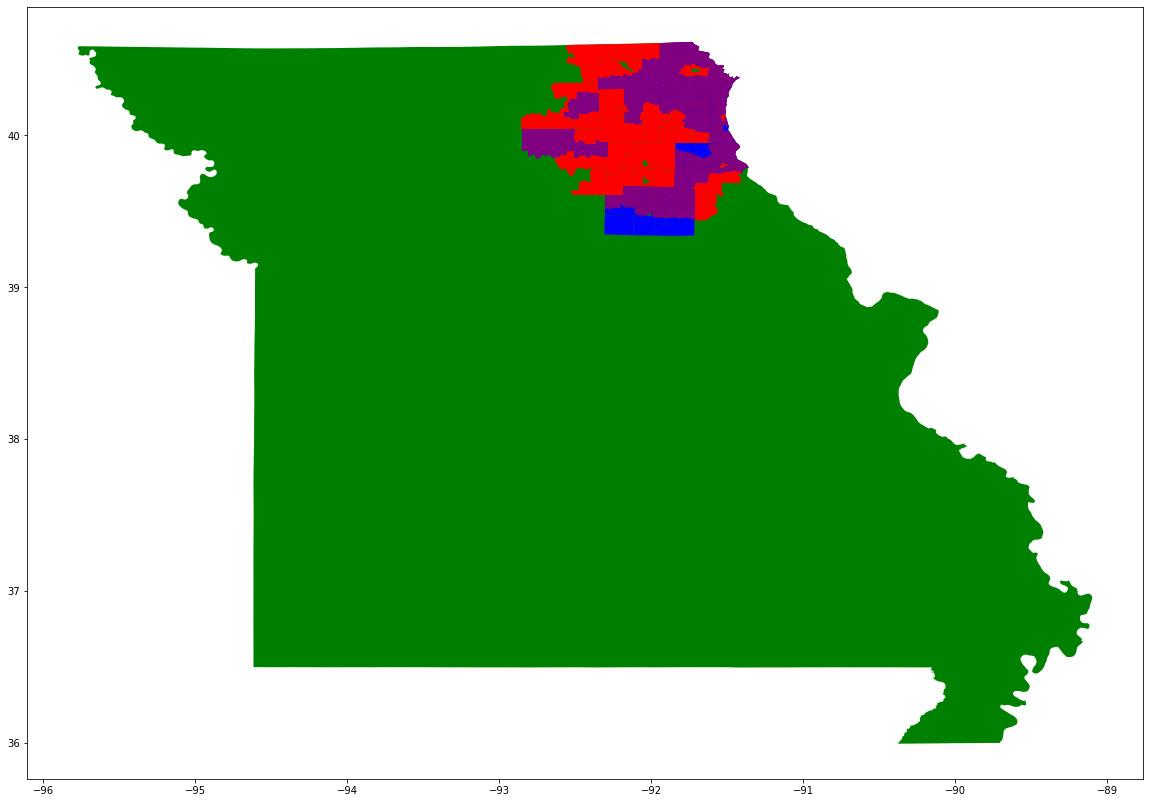

In [10]:
state = "29"
selected_bidder = "Mark Twain Communications Company"
df = geopandas.GeoDataFrame(columns=['color', 'geometry'])
df1 = geopandas.GeoDataFrame(columns=['color', 'geometry'])
df2 = geopandas.GeoDataFrame(columns=['color', 'geometry'])
df3 = geopandas.GeoDataFrame(columns=['color', 'geometry'])
df4 = geopandas.GeoDataFrame(columns=['color', 'geometry'])

df.loc[0] = ['green', state_shapes.loc[state_shapes["STATEFP"] == state].geometry.item()] 

n = set(all_neighbors[state][selected_bidder])
b = set(all_bidders[state][selected_bidder])
combined = n.intersection(b)

df1["geometry"] = county_shapes.loc[county_shapes.GEOID.isin(n)].geometry
df1["color"] = "red"

df2["geometry"] = county_shapes.loc[county_shapes.GEOID.isin(b)].geometry
df2["color"] = "blue"

df3["geometry"] = county_shapes.loc[county_shapes.GEOID.isin(combined)].geometry
df3["color"] = "purple"

df = pd.concat([df, df1, df2, df3])

df.plot(color=df['color'], figsize=(20, 15))


<AxesSubplot:>

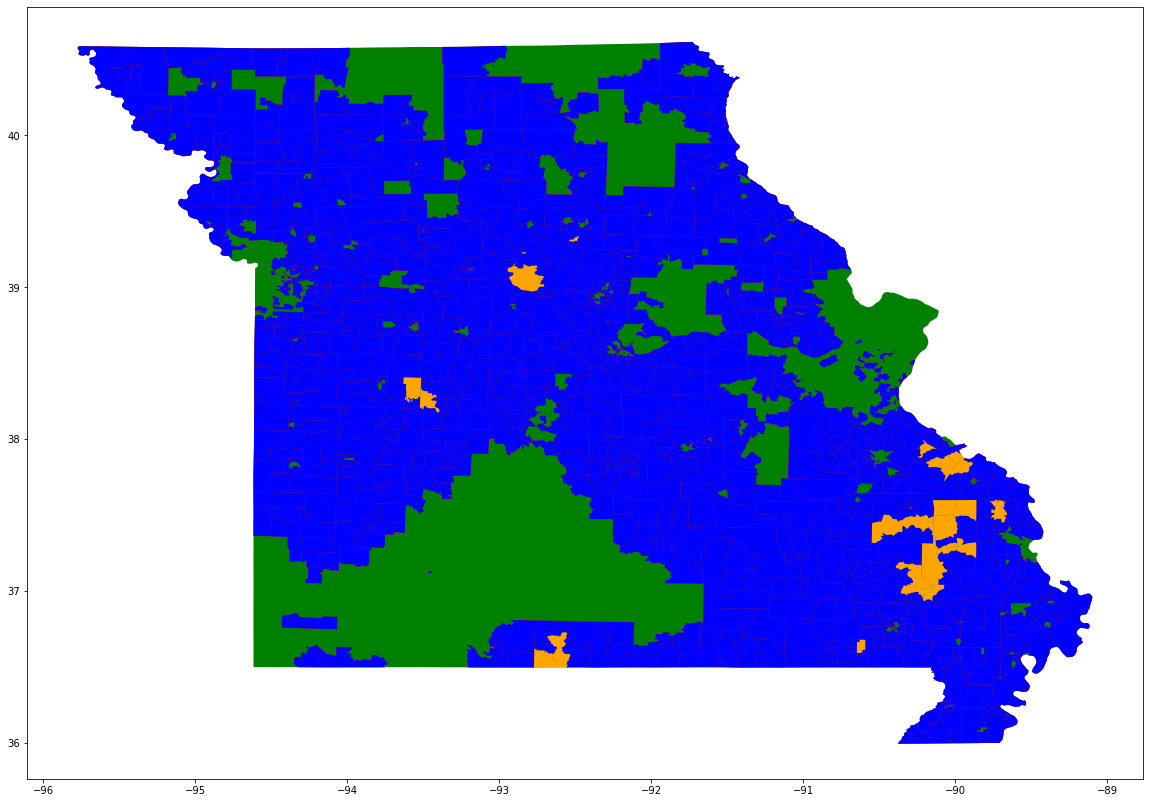

In [11]:
df = geopandas.GeoDataFrame(columns=['color', 'geometry'])
df1 = geopandas.GeoDataFrame(columns=['color', 'geometry'])
df2 = geopandas.GeoDataFrame(columns=['color', 'geometry'])
df3 = geopandas.GeoDataFrame(columns=['color', 'geometry'])
df4 = geopandas.GeoDataFrame(columns=['color', 'geometry'])
df5 = geopandas.GeoDataFrame(columns=['color', 'geometry'])

df.loc[0] = ['green', state_shapes.loc[state_shapes["STATEFP"] == state].geometry.item()] 

bid = set(processed_bid_dict[state].GEOID)
elig = set(eligible.loc[eligible.state_abbreviation=="MO"].cbg_id)
exis = set(existing.loc[existing.state==int(state)].bg).intersection(elig)
fresh = elig - exis

df1["geometry"] = county_shapes.loc[county_shapes.GEOID.isin(exis)].geometry
df1["color"] = "red"

df2["geometry"] = county_shapes.loc[county_shapes.GEOID.isin(exis.intersection(bid))].geometry
df2["color"] = "blue"

df3["geometry"] = county_shapes.loc[county_shapes.GEOID.isin(fresh)].geometry
df3["color"] = "purple"

df3["geometry"] = county_shapes.loc[county_shapes.GEOID.isin(fresh.intersection(bid))].geometry
df3["color"] = "orange"

df = pd.concat([df, df1, df2, df3, df4, df5])

df.plot(color=df['color'], figsize=(20, 15))


<AxesSubplot:>

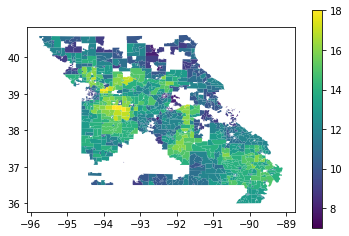

In [12]:
processed_bid_dict[state]["num_bidders"] = processed_bid_dict[state].bidder.apply(len)
fig, ax = plt.subplots(1, 1)
geopandas.GeoDataFrame(processed_bid_dict[state]).plot(column="num_bidders", ax=ax, legend=True, figsize=(20,15)) 

<AxesSubplot:>

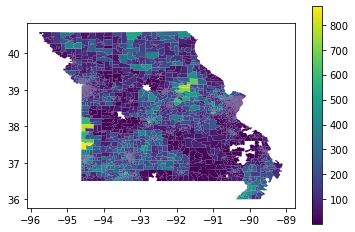

In [13]:
df = existing.loc[existing["state"]==int(state)].groupby("bg")["names"].apply(len).reset_index(name="num_existing")
df = df.merge(county_shapes, left_on="bg", right_on="GEOID")
fig, ax = plt.subplots(1, 1)
geopandas.GeoDataFrame(df).plot(column= "num_existing",ax=ax, legend=True, figsize=(20,15)) 

In [14]:
bids_unfiltered["combined_pk"] = bids_unfiltered["bidder"] + bids_unfiltered["census_id"].astype(str)
final_rounds = bids_unfiltered.groupby("combined_pk").agg({'round': 'max','bidder':'first','census_id':'first'})
winners = pd.read_csv("data/all_assigned_census_blocks.csv")[["bidder","block_id","state","census_id"]]
winners = winners.groupby(['bidder','census_id'], as_index=False).agg({"block_id":list, "state":"first"})
winners

,bidder,census_id,block_id,state
0,4-Corners Consortium,350319437004,"[350319437004005, 350319437004010, 35031943700...",NM
1,4-Corners Consortium,350319438004,"[350319438004000, 350319438004003, 35031943800...",NM
2,AB Indiana LLC,120210112021,"[120210112021071, 120210112021072, 12021011202...",FL
3,ACT,281159504002,"[281159504002011, 281159504002012, 28115950400...",MS
4,ACT,281159505001,"[281159505001024, 281159505001026, 28115950500...",MS
...,...,...,...,...
57167,"Yucca Telecommunications Systems, Inc.",350410003002,"[350410003002004, 350410003002063]",NM
57168,"Yucca Telecommunications Systems, Inc.",350410003003,[350410003003024],NM
57169,"Zito West Holding, LLC",420879605002,"[420879605002001, 420879605002004, 42087960500...",PA
57170,yondoo Broadband LLC,291138101002,"[291138101002030, 291138101002058, 29113810100...",MO


In [15]:
def explode_processed_bids(processed_bid_dict):
    list_of_rows = []
    for k, v in processed_bid_dict.items():
        for idx, row in v.iterrows():
            for bidder, neighboring_bg in row.neighbors[0].items():
                list_of_rows.append([bidder, row.bidder, row.GEOID, row.geometry, [neighboring_bg]])
    return geopandas.GeoDataFrame(list_of_rows, columns=["bidder", "competitors", "GEOID", "geometry", "neighbors"])
exploded_df = explode_processed_bids(processed_bid_dict)

In [16]:
exploded_df = exploded_df.merge(final_rounds, left_on=["GEOID", "bidder"], right_on=["census_id", "bidder"])
exploded_df_winner = exploded_df.merge(winners, on=["census_id", "bidder"])
final_rounds_winner = final_rounds.merge(winners, on=["census_id", "bidder"])
exploded_df_winner

,bidder,competitors,GEOID,geometry,neighbors,round,census_id,block_id,state
0,"CenturyLink, Inc.","{Hughes Network Systems, LLC, Simple Networks ...",10059503001,"POLYGON ((-85.58226 31.75380, -85.58225 31.753...","[[10059503001, 10059503002, 10059504001, 10059...",13,10059503001,"[10059503001000, 10059503001002, 1005950300100...",AL
1,"CenturyLink, Inc.","{Hughes Network Systems, LLC, Simple Networks ...",10059503002,"POLYGON ((-85.70896 31.71170, -85.70831 31.712...","[[10059503001, 10059503002, 10059504002, 10059...",13,10059503002,"[10059503002000, 10059503002001, 1005950300200...",AL
2,"CenturyLink, Inc.","{Hughes Network Systems, LLC, Simple Networks ...",10059504001,"POLYGON ((-85.58716 31.72665, -85.58665 31.726...","[[10059503001, 10059504001, 10059504002, 10450...",13,10059504001,"[10059504001000, 10059504001001, 1005950400100...",AL
3,"CenturyLink, Inc.","{Hughes Network Systems, LLC, Simple Networks ...",10139530001,"POLYGON ((-86.90894 31.96167, -86.90632 31.961...","[[10139527001, 10139529001, 10139530001, 10139...",13,10139530001,"[10139530001000, 10139530001001, 1013953000101...",AL
4,"CenturyLink, Inc.","{Hughes Network Systems, LLC, Simple Networks ...",10139530002,"POLYGON ((-86.90735 31.84696, -86.90731 31.847...","[[10139529001, 10139530001, 10139530002, 10139...",13,10139530002,"[10139530002001, 10139530002004, 1013953000200...",AL
...,...,...,...,...,...,...,...,...,...
3235,"Visionary Communications, Inc.","{Hughes Network Systems, LLC, Simple Networks ...",560330006002,"POLYGON ((-107.30168 44.91839, -107.30160 44.9...","[[300039404001, 300039407001, 560330004001, 56...",17,560330006002,"[560330006002133, 560330006002134, 56033000600...",WY
3236,"Visionary Communications, Inc.","{Hughes Network Systems, LLC, Simple Networks ...",560330006003,"POLYGON ((-107.14372 44.76929, -107.14359 44.7...","[[560330001004, 560330002003, 560330003003, 56...",17,560330006003,"[560330006003009, 560330006003028, 56033000600...",WY
3237,"Visionary Communications, Inc.","{Hughes Network Systems, LLC, Simple Networks ...",560350001021,"POLYGON ((-109.89360 42.86531, -109.89351 42.8...","[[560130003002, 560139401001, 560350001011, 56...",14,560350001021,"[560350001021000, 560350001021004, 56035000102...",WY
3238,"CenturyLink, Inc.","{Hughes Network Systems, LLC, Simple Networks ...",560350001022,"POLYGON ((-110.53416 43.28313, -110.53392 43.2...","[[560350001011, 560350001021, 560350001022, 56...",12,560350001022,"[560350001022009, 560350001022028, 56035000102...",WY


In [17]:
all_bids_by_bidder = final_rounds.groupby("bidder")["census_id"].apply(set).reset_index(name="all_bids")
all_bids_by_bidder = {k:v for k, v in zip(all_bids_by_bidder.bidder, all_bids_by_bidder.all_bids)}

all_neighbored_bids_by_bidder = exploded_df.groupby("bidder")["GEOID"].apply(set).reset_index(name="all_bids")
all_neighbored_bids_by_bidder = {k:v for k, v in zip(all_neighbored_bids_by_bidder.bidder, all_neighbored_bids_by_bidder.all_bids)}

all_neighbors_by_bidder = exploded_df.groupby("bidder")["neighbors"].apply(lambda x: set([z for y in x for z in y[0]])).reset_index(name="all_bids")
all_neighbors_by_bidder = {k:v for k, v in zip(all_neighbors_by_bidder.bidder, all_neighbors_by_bidder.all_bids)}

average_round_by_bidder = final_rounds.groupby("bidder")["round"].mean().reset_index(name="average_final_round")
average_round_by_bidder = {k:v for k, v in zip(average_round_by_bidder.bidder, average_round_by_bidder.average_final_round)}


all_bids_by_bidder_winner = final_rounds_winner.groupby("bidder")["census_id"].apply(set).reset_index(name="all_bids")
all_bids_by_bidder_winner = {k:v for k, v in zip(all_bids_by_bidder_winner.bidder, all_bids_by_bidder_winner.all_bids)}

all_neighbored_bids_by_bidder_winner = exploded_df_winner.groupby("bidder")["GEOID"].apply(set).reset_index(name="all_bids")
all_neighbored_bids_by_bidder_winner = {k:v for k, v in zip(all_neighbored_bids_by_bidder_winner.bidder, all_neighbored_bids_by_bidder_winner.all_bids)}

all_neighbors_by_bidder_winner = exploded_df_winner.groupby("bidder")["neighbors"].apply(lambda x: set([z for y in x for z in y[0]])).reset_index(name="all_bids")
all_neighbors_by_bidder_winner = {k:v for k, v in zip(all_neighbors_by_bidder_winner.bidder, all_neighbors_by_bidder_winner.all_bids)}

average_round_by_bidder_winner = final_rounds_winner.groupby("bidder")["round"].mean().reset_index(name="average_final_round")
average_round_by_bidder_winner = {k:v for k, v in zip(average_round_by_bidder_winner.bidder, average_round_by_bidder_winner.average_final_round)}

won_blocks = final_rounds_winner.groupby("bidder").agg({"census_id":list, "block_id":list}).reset_index()
won_blocks = {b:{c_id:len(b_id) for c_id, b_id in zip(c_ids, b_ids)} for b, c_ids, b_ids in zip(won_blocks.bidder, won_blocks.census_id, won_blocks.block_id)}


In [18]:
big_table_rows = []
for bidder, all_bids in all_bids_by_bidder.items():
    average_round = average_round_by_bidder[bidder]
    neighbored_bids = all_neighbored_bids_by_bidder.get(bidder, set())
    neighbors = all_neighbors_by_bidder.get(bidder, set())
    
    wild_tract_bg = all_bids - neighbored_bids
    strict_neighbor_bg = neighbored_bids - neighbors
    existing_bg = neighbored_bids.intersection(neighbors)
    
    
    average_round_winner = average_round_by_bidder_winner.get(bidder, 0)
    all_bids_winner = all_bids_by_bidder_winner.get(bidder, set([""]))
    neighbored_bids_winner = all_neighbored_bids_by_bidder_winner.get(bidder, set())
    neighbors_winner = all_neighbors_by_bidder_winner.get(bidder, set())
    
    wild_tract_bg_winner = all_bids_winner - neighbored_bids_winner
    strict_neighbor_bg_winner = neighbored_bids_winner - neighbors_winner
    existing_bg_winner = neighbored_bids_winner.intersection(neighbors_winner)
    
    total_blocks = wild_blocks = strict_blocks = existing_blocks = 0
    for c_id, count in won_blocks.get(bidder, dict()).items():
        if c_id in wild_tract_bg_winner:
            wild_blocks+=count
        elif c_id in strict_neighbor_bg_winner:
            strict_blocks+=count
        else:
            existing_blocks+=count
        total_blocks+=count

    big_table_rows.append([bidder, len(wild_tract_bg), len(strict_neighbor_bg),len(existing_bg), len(neighbors),
                           len(all_bids), average_round, len(wild_tract_bg_winner), len(strict_neighbor_bg_winner),
                           len(existing_bg_winner), len(neighbors_winner), len(all_bids_winner), average_round_winner,
                           wild_blocks, strict_blocks, existing_blocks, total_blocks
                          ])
big_table_rows = sorted(big_table_rows, key=lambda x:x[2]+x[3])
percent_neighbor_by_bidder = pd.DataFrame(big_table_rows, columns=["bidder", "wild tract bids", "strict neighbor bids",
                                                                   "existing bg bids", "average neighbors per bid",
                                                                   "num bids", "average final round number",
                                                                   "wild tract bids winner",
                                                                   "strict neighbor bids winner",
                                                                   "existing bg bids winner",
                                                                   "average neighbors per bid winner", "num wins",
                                                                   "average final round number winner",
                                                                   "won blocks in wild tract bg", 
                                                                   "won blocks in strict neighbor bg", 
                                                                   "won blocks in existing bg", "total blocks won" 
                                                                  ])
percent_neighbor_by_bidder.to_csv("bidder_neighbor_percentage.csv", index=False)

<AxesSubplot:>

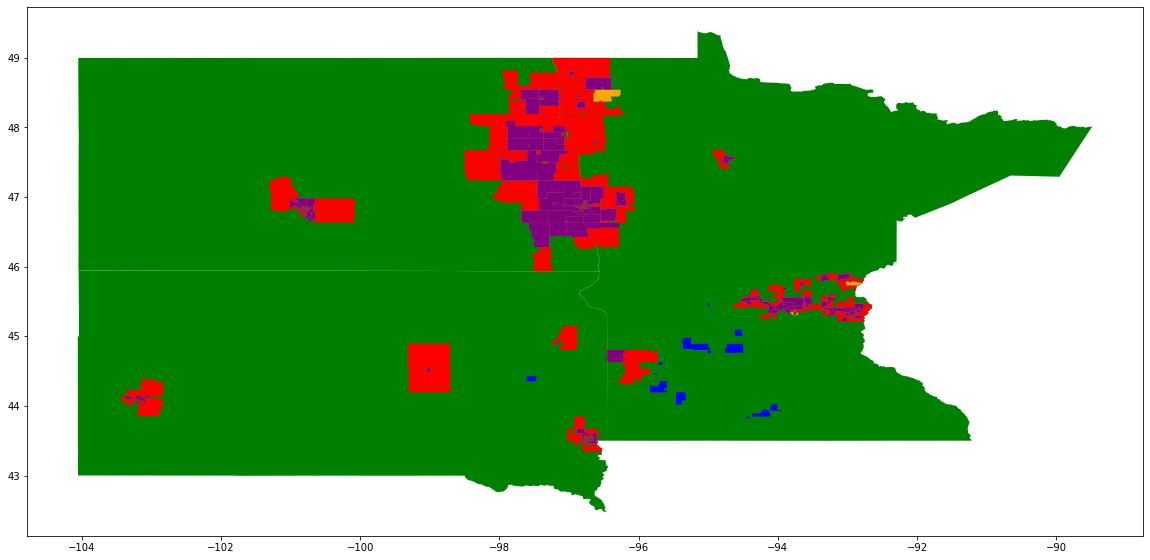

In [19]:
states = ["27", "38", "46"]
selected_bidder = "Midcontinent Communications"
df = geopandas.GeoDataFrame(columns=['color', 'geometry'])
df1 = geopandas.GeoDataFrame(columns=['color', 'geometry'])
df2 = geopandas.GeoDataFrame(columns=['color', 'geometry'])
df3 = geopandas.GeoDataFrame(columns=['color', 'geometry'])
df4 = geopandas.GeoDataFrame(columns=['color', 'geometry'])

df["geometry"] = state_shapes.loc[state_shapes["STATEFP"].isin(states)].geometry
df["color"] = "green"

n = set(all_neighbors_by_bidder[selected_bidder])
h = set(all_neighbored_bids_by_bidder[selected_bidder])
b = set(all_bids_by_bidder[selected_bidder])
combined = n.intersection(b)

df1["geometry"] = county_shapes.loc[county_shapes.GEOID.isin(n)].geometry
df1["color"] = "red"

df2["geometry"] = county_shapes.loc[county_shapes.GEOID.isin(b)].geometry
df2["color"] = "blue"

df3["geometry"] = county_shapes.loc[county_shapes.GEOID.isin(h)].geometry
df3["color"] = "orange"

df4["geometry"] = county_shapes.loc[county_shapes.GEOID.isin(combined)].geometry
df4["color"] = "purple"

df = pd.concat([df, df1, df2, df3, df4])

df.plot(color=df['color'], figsize=(20, 15))
